In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.constants as const

In [2]:
freqs = [98, 223.5 ,339.7672758867]
eisfreq = (const.c / (850*u.micron)).to(u.GHz).value
data = Table.read('/home/jotter/nrao/summer_research_2018/tables/r0.5_catalog_bgfit_may21_ulim.fits')
calc = Table.read('/home/jotter/nrao/summer_research_2018/tables/r0.5_may21_calc_vals_mask_alpha.fits')

In [3]:
def specind_compute(freq1, freq2, flux1, flux2, flux1_err, flux2_err):
    freqdiff = np.log10(freq2) - np.log10(freq1)
    specind = (np.log10(flux2)-np.log10(flux1))/freqdiff
    error = np.sqrt((flux1_err/(freqdiff*np.log(10)*flux1))**2 + (flux2_err/(freqdiff*np.log(10)*flux2))**2)
    return specind, error

In [4]:
b3flux = data['ap_flux_B3'].data
b3flux_err = data['ap_flux_err_B3'].data
b6flux = data['ap_flux_B6'].data
b6flux_err = data['ap_flux_err_B6'].data
b7flux = data['ap_flux_B7'].data
b7flux_err = data['ap_flux_err_B7'].data

In [5]:
b6b7_specind, b6b7_specind_err = specind_compute(freqs[2],freqs[1],b7flux, b6flux, b7flux_err, b6flux_err)
b3b6_specind, b3b6_specind_err = specind_compute(freqs[1],freqs[0],b6flux, b3flux, b6flux_err, b3flux_err)

In [6]:
b3b6_ind = np.where(np.isnan(b3b6_specind) == False)[0]
b6b7_ind = np.where(np.isnan(b6b7_specind) == False)[0]
print(len(b3b6_ind), len(b6b7_ind))

49 33


In [7]:
sys_err = 0.20 #20% systematic error

b3flux = data['ap_flux_B3'].data
b3flux_err = np.sqrt(data['ap_flux_err_B3'].data**2 + (sys_err*b3flux)**2)
b6flux = data['ap_flux_B6'].data
b6flux_err = np.sqrt(data['ap_flux_err_B6'].data**2 + (sys_err*b6flux)**2)
b7flux = data['ap_flux_B7'].data
b7flux_err = np.sqrt(data['ap_flux_err_B7'].data**2 + (sys_err*b7flux)**2)

In [8]:
b6b7_specind, b6b7_specind_err_sys = specind_compute(freqs[2],freqs[1],b7flux, b6flux, b7flux_err, b6flux_err)
b3b6_specind, b3b6_specind_err_sys = specind_compute(freqs[1],freqs[0],b6flux, b3flux, b6flux_err, b3flux_err)

In [10]:
##get spectral index upper limits:
b6_ulim_ind = np.where(np.isnan(data['B6_flux_ulim']) == False)[0] #upper limit for B6
b7_nodet_ind = np.where(np.isnan(data['ap_flux_B7']) == True)[0] #no detection in B7
ulim_ind = np.intersect1d(b6_ulim_ind, b7_nodet_ind)
fit_ind = np.where(np.isnan(calc['alpha_fit'])==False)[0]
ulim_ind = np.setdiff1d(ulim_ind, fit_ind)
print(ulim_ind)

b3flux = data['ap_flux_B3'][ulim_ind] * 1000
b3flux_err = data['ap_flux_err_B3'][ulim_ind] * 1000 #errors don't actually matter here
b6ulim = data['B6_flux_ulim'][ulim_ind]
b6ulim_err = data['B6_flux_ulim'][ulim_ind] * 0.2
b7ulim = data['B7_flux_ulim'][ulim_ind]
b7ulim_err = data['B7_flux_ulim'][ulim_ind] * 0.2

b3b6_ulim, b3b6_ulim_err = specind_compute(freqs[1],freqs[0],b6ulim, b3flux, b6ulim_err, b3flux_err)
b3b7_ulim, b3b7_ulim_err = specind_compute(freqs[2],freqs[0],b7ulim, b3flux, b7ulim_err, b3flux_err)

[37 38 43 53 56 58]


In [11]:
calc['alpha_ulim_B3B6'] = np.repeat(np.nan, len(calc))
calc['alpha_ulim_B3B6'][ulim_ind] = b3b6_ulim

In [12]:
eisner_full = Table.read('/home/jotter/nrao/tables/eisner_tbl.txt', format='ascii')
eisner_coord = Table.read('/home/jotter/nrao/tables/eis_coord_table.fits')
match_eis = Table.read('/home/jotter/nrao/tables/eis_r0.5_may21_match.fits')
nondet_eis_match = Table.read('/home/jotter/nrao/tables/eis_nondet_ir_nondet.fits')

match_eis_ind = []

for ID in match_eis['ID_2']:
    match_eis_ind.append(np.where(eisner_full['ID'] == ID.strip())[0][0])
    
eis_match = eisner_full[match_eis_ind]

eis_flux = []
eis_flux_err = []
for fstr in eis_match['F_lambda 850mum']:
    split = fstr.split(' ')
    eis_flux.append(float(split[0]))
    eis_flux_err.append(float(split[-1]))
    
eis_flux = np.array(eis_flux)
eis_flux_err = np.array(eis_flux_err)
b3flux = match_eis['ap_flux_B3'] * 1000
b3flux_err = np.sqrt((match_eis['ap_flux_err_B3']*1000)**2 + (b3flux*0.2)**2)
b3eis_specind, b3eis_specind_err = specind_compute(freqs[0], eisfreq, b3flux, eis_flux, b3flux_err, eis_flux_err)

In [13]:
calc['alpha_B3eis'] = np.repeat(np.nan, len(calc))
calc['alpha_B3eis_err'] = np.repeat(np.nan, len(calc))
b3eis_ind = match_eis['ID_1']
#b3eis_ind = np.setdiff1d(match_eis['ID_1'], np.array([4,6,11]))
calc['alpha_B3eis'][b3eis_ind] = b3eis_specind
calc['alpha_B3eis_err'][b3eis_ind] = b3eis_specind_err

In [14]:
calc.write('/home/jotter/nrao/summer_research_2018/tables/r0.5_may21_calc_vals_mask_alpha_ulim.fits', overwrite=True)

In [15]:
nondet_fov_ind = []
eisner_full_id = np.array([idstr.strip() for idstr in eisner_full['ID']])
for nondet_id in nondet_eis_match['ID']:
    nondet_id = nondet_id.strip()
    ind = np.where(eisner_full_id == nondet_id)[0][0]
    nondet_fov_ind.append(ind)

nondet_eis_full = eisner_full[np.array(nondet_fov_ind)]

In [16]:
b3_ulim = nondet_eis_match['B3_flux_ulim']
b3_ulim_err = b3_ulim*0.2

eis_flux_nd = []
eis_flux_err_nd = []
for fstr in nondet_eis_full['F_lambda 850mum']:
    split = fstr.split(' ')
    eis_flux_nd.append(float(split[0]))
    eis_flux_err_nd.append(float(split[-1]))
eis_flux_nd  = np.array(eis_flux_nd)
eis_flux_err_nd = np.array(eis_flux_err_nd)

b3eis_alpha_llim, b3eis_alpha_llim_err = specind_compute(freqs[0], eisfreq, b3_ulim, eis_flux_nd, b3_ulim_err, eis_flux_err_nd)

39 33
85 39 13 33 6


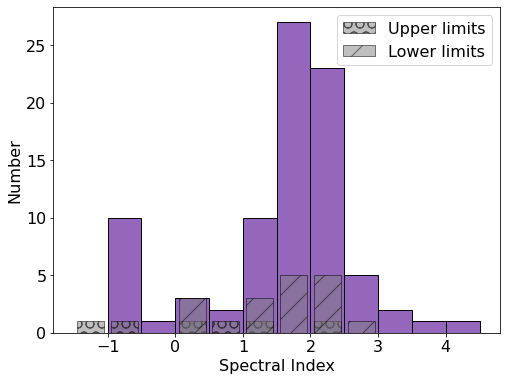

In [17]:
##creating spectral index histogram - including eisner spectral indices

plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(8,6))
specind_fit = calc['alpha_fit']
fit_ind = np.where(np.isnan(specind_fit) == False)[0]
b3b6_only = np.setdiff1d(b3b6_ind, fit_ind)
eis_ind = np.where(np.isnan(calc['alpha_B3eis'])==False)[0]
eis_only = np.setdiff1d(eis_ind, fit_ind)

specind_fit = specind_fit[fit_ind]
specind_fit_err = calc['alpha_fit_err'][fit_ind]
specind_b3b6_only = calc['alpha_B3B6'][b3b6_only]
specind_b3b6_only_err = calc['alpha_B3B6_err'][b3b6_only]
print(len(eis_ind), len(eis_only))
specind_eis_only = calc['alpha_B3eis'][eis_only]
specind_eis_only_err = calc['alpha_B3eis_err'][eis_only]

total_alpha = np.concatenate((specind_fit,specind_b3b6_only, specind_eis_only))
total_alpha_err = np.concatenate((specind_fit_err, specind_b3b6_only_err, specind_eis_only_err))
bins = np.arange(-1.5, 5, 0.5)
plt.hist(total_alpha, bins=bins,color='tab:purple', edgecolor='k')

ulim_alpha = calc['alpha_ulim_B3B6']
ulim_alpha = ulim_alpha[np.isnan(ulim_alpha) == False]
plt.hist(ulim_alpha, bins=bins,color='gray', edgecolor='k', alpha=0.5, hatch='O', label='Upper limits', rwidth=0.8)

plt.hist(b3eis_alpha_llim, bins=bins,color='gray', edgecolor='k', alpha=0.5, hatch='/', label='Lower limits', rwidth=0.8)
plt.legend()
plt.xlabel('Spectral Index')
plt.ylabel('Number')
print(len(total_alpha), len(fit_ind), len(b3b6_only), len(specind_eis_only), len(ulim_alpha))
plt.savefig('/home/jotter/nrao/plots/alpha_hist.pdf', bbox_inches='tight')

In [ ]:
b3b6_alpha = calc['alpha_B3B6']
b3b6_alpha_err = calc['alpha_B3B6_err']
b6b7_alpha = calc['alpha_B6B7']
b6b7_alpha_err = calc['alpha_B6B7_err']
alpha = calc['alpha_fit']
alpha_err = calc['alpha_fit_err']

In [140]:
##now find where the vaues agree with 2
alpha2 = np.where(np.abs(total_alpha - 2) <=  3*total_alpha_err)[0]
print(alpha2, len(alpha2))

alpha_close2 = np.where(np.abs(total_alpha - 2) <= 0.5)[0]
#print(alpha_close2, len(alpha_close2))

alphag2 = np.where(total_alpha - 2 >  3*total_alpha_err)[0]
print(alphag2, len(alphag2))

alphal2 = np.where(2 - total_alpha > 3*total_alpha_err)[0]
print(alphal2, len(alphal2))

alpha24 = np.where(2.4 - total_alpha <=  3*total_alpha_err)[0]
print(alpha24, len(alpha24))
print(total_alpha[alpha24])

[ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31 32 33 34 35 36 37 39 41 43 45 46 47 48 49 51 54 57 58
 59 62 66 68 69 70 75 76 77 82] 58
[38 40 42 44] 4
[ 6 25 50 52 53 55 56 60 61 63 64 65 67 71 72 73 74 78 79 80 81 83 84] 23
[ 0  1  2  3  4  5  7  8  9 10 12 13 14 16 17 18 20 21 22 23 24 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 49 57 59 69] 47
[1.19939063 1.10556168 1.98181565 2.00848386 2.12758724 2.05153496
 2.04327796 2.09011784 2.83220038 2.34825301 1.57548438 2.39286437
 2.20403329 2.40175332 2.13171912 2.35214808 1.89971481 1.9717476
 1.77621602 2.32700557 1.90306809 2.68306769 1.7294879  2.42278457
 2.01318233 1.71913237 2.73936137 1.56057699 2.12560587 1.37614491
 2.00020626 2.12653567 2.28672315 3.60049339 1.83138712 4.35475107
 2.23389883 3.2703883  2.36742273 3.12805326 2.59936114 2.45225294
 2.85605236 2.26038354 1.99004992 1.94787367 2.02493948]


In [132]:
alphal0 = np.where(total_alpha + 3*total_alpha_err <= 0)[0]
print(alphal0, len(alphal0))

[63 64 73 74 78 79 80 81 84] 9


In [150]:
match_eis_ind = np.where(match_eis['ID_1'] == 19)
print(match_eis[match_eis_ind]['ID_2'])
print(eis_match[match_eis_ind]['ID'])
print(eis_match[match_eis_ind]['F_lambda 850mum'])

   ID_2  
---------
HC447    
  ID 
-----
HC447
F_lambda 850mum
---------------
   1.6 +or- 0.3


In [129]:
eis_fdust = []
eis_fdust_err = []
for fstr in eis_match['F_dust']:
    split = fstr.split(' ')
    eis_fdust.append(float(split[0]))
    eis_fdust_err.append(float(split[-1]))
    
eis_fdust = np.array(eis_fdust)
    
ff_ind = np.where(eis_fdust == 0.0)
ff_cont_ind = np.where(eis_flux - eis_fdust > eis_flux_err)

In [130]:
print(b3eis_specind[ff_ind] + 3*b3eis_specind_err[ff_ind])
print(b3eis_specind[ff_cont_ind] + 3*b3eis_specind_err[ff_cont_ind])

     ap_flux_B3     
--------------------
-0.09420096630005637
 -0.3433744997252077
  0.2837327720924503
-0.36415320157576564
-0.28530526017089464
 -0.4474587353022407
-0.10261329548619313
     ap_flux_B3     
--------------------
    1.53572734375194
  0.8171412373229117
-0.09420096630005637
 -0.3433744997252077
  0.2837327720924503
-0.36415320157576564
-0.28530526017089464
 -0.1509770211963688
 -0.4474587353022407
-0.20742094729553096
-0.10422174750565016
  0.6205516435844293
-0.10261329548619313


In [131]:
len(ff_cont_ind[0]), len(eis_flux)

(13, 39)

In [ ]:
## get spectral ind

eis_flux = np.array(eis_flux)
eis_flux_err = np.array(eis_flux_err)
b3flux = match_eis['ap_flux_B3'] * 1000
b3flux_err = np.sqrt((match_eis['ap_flux_err_B3']*1000)**2 + (b3flux*0.2)**2)
b3eis_specind, b3eis_specind_err = specind_compute(freqs[0], eisfreq, b3flux, eis_flux, b3flux_err, eis_flux_err)

eis_fdust = np.array(eis_fdust)
eis_fdust_err = np.array(eis_fdust_err)
b3eis_specind_fdust, b3eis_specind_err_fdust = specind_compute(freqs[0], eisfreq, b3flux, eis_fdust, b3flux_err, eis_fdust_err)

nodust_ind = np.where(np.isinf(b3eis_specind_fdust)==True)
print(b3eis_specind[nodust_ind])

In [ ]:
b6flux = match_eis['ap_flux_B6']
print(b6flux[np.isnan(b6flux)==False])
print(match_eis['ID_1'][np.isnan(b6flux)==False])
print(eis_flux[np.isnan(b6flux)==False])
print(eis_flux_err[np.isnan(b6flux)==False])

In [ ]:
plt.hist(b3eis_specind)

In [ ]:
plt.hist(b3eis_specind_fdust[b3eis_specind_fdust > -10])

In [ ]:
b3eis_specind[-1], b3eis_specind_err[-1], b3flux[-1], b3flux_err[-1], eis_flux[-1], eis_flux_err[-1]

In [ ]:
np.where(np.abs(2 - b3eis_specind) > 3*b3eis_specind_err)

In [ ]:
##unmatched eisner sources:
eisner_full_id = [st.strip() for st in eisner_full['ID']]
matched_eis_id = [st.strip() for st in match_eis['ID_2']]
nondet_eis = np.setdiff1d(eisner_full_id, matched_eis_id)

nondet_eis_ind = []
for ID in nondet_eis:
    nondet_eis_ind.append(np.where(eisner_full['ID'] == ID.strip())[0][0])
    
nondet_eis = eisner_coord[nondet_eis_ind]
#nondet_eis.write('/home/jotter/nrao/tables/eis_nondet_full.fits', overwrite=True)

In [ ]:
nondet_coord = SkyCoord(nondet_eis['RA'], nondet_eis['DEC'], unit=u.degree)
srcI = SkyCoord(data['RA_B3'][26], data['DEC_B3'][26], unit=u.degree)

dist = nondet_coord.separation(srcI)
fov_ind = np.where(dist < 65*u.arcsecond)

In [ ]:
nondet_eis_fov = nondet_eis[fov_ind]
#nondet_eis_fov.write('/home/jotter/nrao/tables/eis_nondet_fov.fits', overwrite=True)

In [ ]:
match_eis_ind_nondet = []
for ID in nondet_eis_fov['ID']:
    match_eis_ind_nondet.append(np.where(eisner_full['ID'] == ID.strip())[0][0])
    
nondet_eis_fov_full = eisner_full[match_eis_ind_nondet]

In [ ]:
eis_flux_nd = []
eis_flux_err_nd = []
for fstr in nondet_eis_fov_full['F_lambda 850mum']:
    split = fstr.split(' ')
    eis_flux_nd.append(float(split[0]))
    eis_flux_err_nd.append(float(split[-1]))
eis_flux_nd  = np.array(eis_flux_nd)
eis_flux_err_nd = np.array(eis_flux_err_nd)

eis_fdust_nd = []
eis_fdust_err_nd = []
for fstr in nondet_eis_fov_full['F_dust']:
    split = fstr.split(' ')
    eis_fdust_nd.append(float(split[0]))
    eis_fdust_err_nd.append(float(split[-1]))
eis_fdust_nd  = np.array(eis_fdust_nd)
eis_fdust_err_nd = np.array(eis_fdust_err_nd)

In [ ]:
nondet_eis_match = Table.read('/home/jotter/nrao/tables/eis_nondet_ir_nondet.fits')
b3_ulim = nondet_eis_match['B3_flux_ulim']
b3_ulim_err = b3_ulim*0.2
b3eis_alpha_llim, b3eis_alpha_llim_err = specind_compute(freqs[0], eisfreq, b3_ulim, eis_flux_nd, b3_ulim_err, eis_flux_err_nd)
b3eis_alpha_llim_fdust, b3eis_alpha_llim_fdust_err = specind_compute(freqs[0], eisfreq, b3_ulim, eis_fdust_nd, b3_ulim_err, eis_fdust_err_nd)


In [ ]:
plt.hist(b3eis_alpha_ulim)

In [ ]:
plt.hist(b3eis_alpha_ulim_fdust)

In [ ]:
##creating 2 panel spectral index histogram

plt.rcParams.update({'font.size': 16})

fig, (ax0,ax1) = plt.subplots(1,2,sharey=True,figsize=(8,4))

bins = np.arange(-1.5, 5, 0.5)
ax0.hist(total_alpha, bins=bins,color='tab:purple', edgecolor='k')
ax0.hist(ulim_alpha, bins=bins,color='gray', edgecolor='k', alpha=0.5, hatch='/')

ax0.set_ylabel('Number')

bins2 = np.arange(-2,4,0.75)
plt.hist(b3eis_specind, bins, color='tab:green', edgecolor='k')
ax1.hist(b3eis_alpha_llim, bins, alpha=0.5, hatch='\\', color='gray', edgecolor='k')

fig.text(0.4,0, 'Spectral Index')
plt.subplots_adjust(wspace=0.05)
plt.savefig('/home/jotter/nrao/plots/alpha_hist_2panel.pdf', bbox_inches='tight')

In [ ]:
fb = Table.read('/home/jotter/nrao/summer_research_2018/tables/Forbrich2016_r0.5_mar21.fits')
fb.rename_column('Seq_1','Seq')

In [ ]:
specind_tab = Table((b3b6_ind, b3b6_specind[b3b6_ind], b3b6_specind_err_sys[b3b6_ind],
                     b6b7_specind[b3b6_ind], b6b7_specind_err_sys[b3b6_ind]),
                    names=('Seq', 'b3b6_alpha', 'b3b6_alpha_err', 'b6b7_alpha', 'b6b7_alpha_err'))

In [ ]:
match = join(specind_tab, fb, keys='Seq')

In [ ]:
match